2a

Dataset and DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import requests
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from shutil import copyfile
import os

In [ ]:
os.chdir('/content/drive/MyDrive/MLDL_project')
from datasets.cityscapes import CityscapesDataset
from datasets.gta5 import GTA5

In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

lbl_transform = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

In [ ]:
train_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', transform=[transform,lbl_transform], split='train')
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', transform=[transform,lbl_transform], split='val')

In [ ]:
# Create a DataLoader
from torch.utils.data import DataLoader
dataloader_train = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
dataloader_val = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=8)

In [ ]:
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of validation samples: {num_val_samples}')

Number of training samples: 1572
Number of validation samples: 500


Build model

In [ ]:
# Load pre-trained model

from models.deeplabv2.deeplabv2 import get_deeplab_v2
model = get_deeplab_v2().cuda()

Deeplab pretraining loading...


Trainning and validation process

In [ ]:
from train import train
from validate import validation

In [ ]:
def poly_lr_scheduler(optimizer, init_lr=0.0001, init_lr_cls=0.001, iter=0, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param init_lr_cls is base learning rate for final classifier layer
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """
    # if iter % lr_decay_iter or iter > max_iter:
    # 	return optimizer

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr

    lr_cls = init_lr_cls*(1 - iter/max_iter)**power
    optimizer.param_groups[1]['lr'] = lr_cls
    return lr, lr_cls

In [ ]:
import torch.optim as optim
from timeit import default_timer as timer

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD([
    {'params': [param for name, param in model.named_parameters() if 'layer6' not in name]},
    {'params': model.layer6.parameters(), 'lr': 0.001}
], lr=0.0001, momentum=0.9, weight_decay=0.0005)

# Start the timer
start_time = timer()

# training model
epochs = 50

miou_train_list = []
miou_val_list = []
models = []
for epoch in range(epochs):
    print('--------------------------------------------------------------------------------')
    _, miou_train, miou_per_class_train = train(epoch, model, dataloader_train, criterion, optimizer)
    lr, lr_cls = poly_lr_scheduler(optimizer = optimizer, init_lr=0.0001, init_lr_cls=0.001, iter=epoch, lr_decay_iter=1, max_iter=epochs, power=0.9)
    # every 5 epochs print the miou and loss of validation set
    if epoch % 5 == 0:
      _, miou_val, miou_per_class_val = validation(model, dataloader_val, criterion)
      print('--------------------------------------------------------------------------------')
      miou_train_list.append(miou_train)
      miou_val_list.append(miou_val)
      models.append(model.state_dict())


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch1 Avg. Training Loss: 0.7894998931020271, mIoU: 0.3563438655375018
Avg. Validation Loss: 0.5761174065470696, mIoU: 0.4272110702427245
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Epoch2 Avg. Training Loss: 0.38604568432229774, mIoU: 0.5120813899607533
--------------------------------------------------------------------------------
Epoch3 Avg. Training Loss: 0.30218510392285486, mIoU: 0.5693519434494412
--------------------------------------------------------------------------------
Epoch4 Avg. Training Loss: 0.2715267572390821, mIoU: 0.5975846147876861
--------------------------------------------------------------------------------
Epoch5 Avg. Training Loss: 0.24827395372907926, mIoU: 0.6223462526870978
--------------------------------------------------------------------------------
Epoch6 Avg. Training Loss: 0.23142570084667086, mIoU: 0.6416274560124252
Avg. Valida

In [ ]:
_, miou_val, miou_per_class_val = validation(model, dataloader_val, criterion)

Avg. Validation Loss: 0.3055937270820141, mIoU: 0.5534056861573823


In [ ]:
# save best model
import os
DIR = '/content/drive/MyDrive/MLDL_project/models/deeplabv2/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'deepLabV2_epoch{epochs}.pth'

# delete old model files
if os.path.exists(PATH):
    os.remove(PATH)

model = get_deeplab_v2().cuda()
model.load_state_dict(models[np.argmax(np.array(miou_val_list))])
torch.save(model.state_dict(), PATH)

Deeplab pretraining loading...


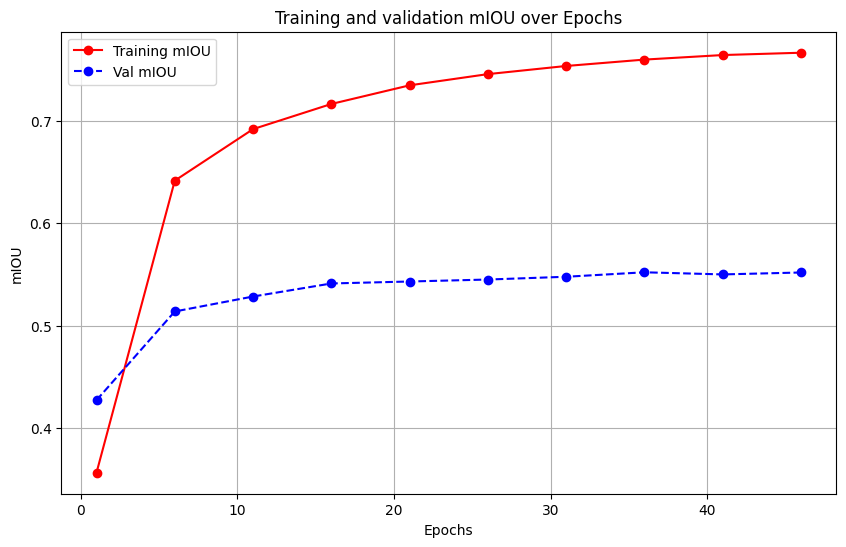

In [ ]:
# visualization
import matplotlib.pyplot as plt

epochs_list = np.arange(1, epochs+1, 5)
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list, marker='o', linestyle='-', color='r', label='Training mIOU')
plt.plot(epochs_list, miou_val_list, marker='o', linestyle='--', color='b', label='Val mIOU')

plt.title('Training and validation mIOU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIOU')

plt.legend()
plt.grid(True)
plt.show()

Flops and Number of parameters

In [ ]:
saved_state_dict = torch.load('/content/drive/MyDrive/MLDL_project/models/deeplabv2/trained_models/deepLabV2_epoch50.pth')
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [ ]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=ea6b04bc6e7d1fdece5dcb33f19e5032a0e8e5918e5f2cba6a62f4152c034dce
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=8b5a8edffa481cd9eb13066435b72d57961e567fa7c8782b9ebbc4737ab8739e
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

model.eval()
height = train_dataset[0][0].shape[0]
width = train_dataset[0][0].shape[1]
image = torch.zeros((1, 3, height, width)).cuda()

flops = FlopCountAnalysis(model, image)
print(flops)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 43901068


In [ ]:
#more detail information about number of parameters and flops
print(flop_count_table(flops))

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 2.911G     |
|  conv1                         |  9.408K                |  4.817M    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  0.164M    |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  56.768M   |
|   layer1.0                     |   75.008K              |   19.847M  |
|    layer1.0.conv1              |    4.096K              |    1.057M  |
|    layer1.0.bn1                |    0.128K              |    82.56K  |
|    layer1.0.conv2              |    36.864K             |    9.511M  |
|    layer1.0.bn2                |    0.128K       

Latency and FPS

In [ ]:
from utils import latency_fps
latency_fps(model, train_dataset, transform, device = 'cuda', iterations = 1000)

Mean Latency: 271.90069913864136 ms
Std Latency: 12.550420683775632 ms
Mean FPS: 3.6973098359332046
Std FPS: 0.5337710481503735
